# Merging GP regression sub-models using PAPL

This notebook illustrates how to use PAPL (Posterior Aggregation using Pseudo-Likelihood) to train an ensemble of Gaussian process models and to make predictions with it.

First, let's load some required packages

In [1]:
cd ..

/Users/nicolasdurrande/projects/guepard


In [2]:
import numpy as np
import gpflow
import guepard
import matplotlib.pyplot as plt

from gpflow.utilities import print_summary
from guepard.gpr_submodels import get_gpr_submodels

from scipy.stats import multivariate_normal as mvn

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 12

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 150em; }</style>"))

/var/folders/hf/nx4hh6mj3bsfyxc4p3splhxr0000gn/T/ipykernel_33571/1363708249.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


We now define a couple of helper functions, and generate a dataset

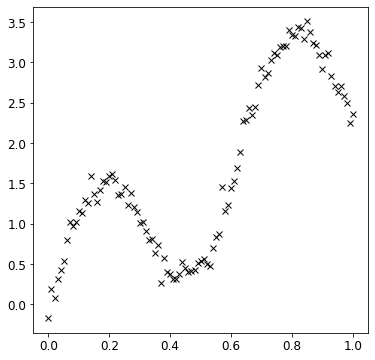

In [3]:
noise_var = 0.01


def f(x):
    return np.sin(10 * x[:, :1]) + 3. * x[:, :1]


X = np.linspace(0, 1, 101)[:, None]
#np.random.shuffle(X)
Y = f(X) + np.sqrt(noise_var) * np.random.normal(size=X.shape)

plt.figure(figsize=(6,6))
plt.plot(X, Y, 'kx')

We now split the dataset in three, and build a GPR model for each of them

In [4]:
num_split = 3

Xl = np.array_split(X, num_split)  # list of num_split np.array
Yl = np.array_split(Y, num_split)  

kernel = gpflow.kernels.Matern32()

# make submodels and aggregate them
M = get_gpr_submodels(zip(Xl, Yl), kernel, noise_variance=noise_var) # list of num_split GPR models

m_agg = guepard.PAPL(M)

`M` is a list of GPR models, let's plot them

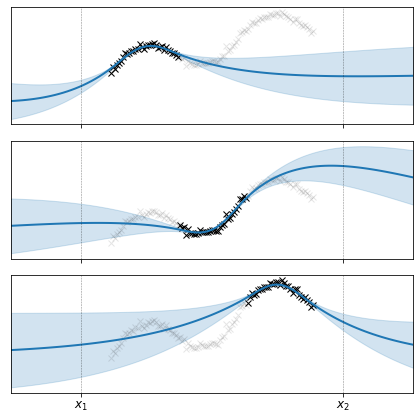

In [22]:
# define plotting helper functions

def plot_mean_conf(x, mean, var, ax, color='C0', alpha=1.):
        ax.plot(x, mean, color, lw=2, alpha=alpha)
        ax.fill_between(
            x[:, 0],
            mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
            mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
            color=color,
            alpha=alpha * 0.2,
        )


def plot_model(m, ax, x=np.linspace(0, 1, 101)[:, None], plot_data=True, color='C0', alpha=1.):
    if plot_data:
        X, Y = m.data
        ax.plot(X, Y, "kx", mew=1.)
    
    mean, var = m.predict_f(x)[:2]
    plot_mean_conf(x, mean, var, ax, color, alpha)


# plot predictions
x = np.linspace(-.5, 1.5, 101)[:, None]
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

for i, m in enumerate(M):    
    ax = axes[i]
    ax.plot(X, Y, 'kx', alpha=0.1)
    plot_model(m, ax, x, alpha=1.)
    ax.set_xlim([-.5, 1.5])
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    [ax.axvline(x, color='k', linestyle="dashed", linewidth=.5, alpha=.5) for x in Xt]
    ax.set_xticks(Xt.flatten().tolist())
    ax.set_xticklabels(["$x_1$", "$x_2$"])
    
#[axes[i].plot(X, Y, 'kx', mew=1., alpha=.1) for i, _ in enumerate(M)];
plt.tight_layout()
plt.savefig(f"toy_submodels.pdf")

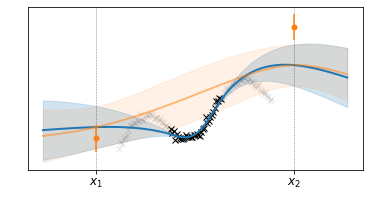

In [6]:
Xt = np.array([[-0.15, 1.15]]).T 
mup, Sp = np.zeros((2, 1)), kernel.K(Xt).numpy()

jitter = 1e-8 * np.eye(2)

me0, Se0 = M[0].predict_f(Xt, full_cov=True)
me0, Se0 = me0.numpy(), Se0.numpy()[0]
Spl0 = Sp @ np.linalg.inv(Sp - Se0 + jitter) @ Sp - Sp
Spl0 = np.linalg.inv(-np.linalg.inv(Sp) + np.linalg.inv(Se0) + jitter)
mpl0 = mup + Sp @ np.linalg.inv(Sp - Se0 + jitter) @ (me0 - mup)

me1, Se1 = M[1].predict_f(Xt, full_cov=True)
me1, Se1 = me1.numpy(), Se1.numpy()[0]
Spl1 = Sp @ np.linalg.inv(Sp - Se1 + jitter) @ Sp - Sp
Spl1 = np.linalg.inv(-np.linalg.inv(Sp) + np.linalg.inv(Se1) + jitter)
mpl1 = mup + Sp @ np.linalg.inv(Sp - Se1 + jitter) @ (me1 - mup)

me2, Se2 = M[2].predict_f(Xt, full_cov=True)
me2, Se2 = me2.numpy(), Se2.numpy()[0]
Spl2 = Sp @ np.linalg.inv(Sp - Se2 + jitter) @ Sp - Sp
Spl2 = np.linalg.inv(-np.linalg.inv(Sp) + np.linalg.inv(Se2) + jitter)
mpl2 = mup + Sp @ np.linalg.inv(Sp - Se2 + jitter) @ (me2 - mup)

# handmade predictions for full implicit posterior
x = np.linspace(-.5, 1.5, 101)[:, None]
kx = kernel.K(x, Xt).numpy()
kxx = kernel.K(x).numpy()
mx = kx @ np.linalg.inv(Sp + Spl1) @ mpl1
vx = kxx - kx @ np.linalg.inv(Sp + Spl1) @ kx.T
vx = np.diag(vx)[:, None]

# plot predictions
fig, axes = plt.subplots(1, 1, figsize=(6, 3))
x = np.linspace(-.5, 1.5, 101)[:, None]
plt.plot(X, Y, 'kx', alpha=0.1)
#[plot_model(m, axes, x, alpha=.3, plot_data=False) for i, m in enumerate(M)];
plot_model(M[1], axes, x)
#[axes[i].plot(X, Y, 'kx', mew=1., alpha=.1) for i, _ in enumerate(M)];
plot_mean_conf(x, mx, vx, axes, 'C1', alpha=.5)

[axes.axvline(x, color='k', linestyle="dashed", linewidth=.5, alpha=.5) for x in Xt]
[plt.plot(x, y, "C1o", ms=5.) for x, y in zip(Xt, mpl1)]
[plt.vlines(x, y-np.sqrt(c), y+np.sqrt(c) , "C1") for x, y, c in zip(Xt, mpl1, np.diag(Spl1))]
axes.set_xticks(Xt.flatten().tolist())
axes.set_yticks([])
axes.set_xticklabels(["$x_1$", "$x_2$"])
axes.set_ylabel(" ")

plt.savefig("toy_implicit_obs.pdf")

We plot the prior, model 1 and the implitic observation at (x1, x2)

/var/folders/hf/nx4hh6mj3bsfyxc4p3splhxr0000gn/T/ipykernel_33571/3677685506.py:10: UserWarning: The following kwargs were not used by contour: 'label'
  fig = plt.contour(x, y, Z, colors=color, levels=3, linestyles=linestyles, label='label')


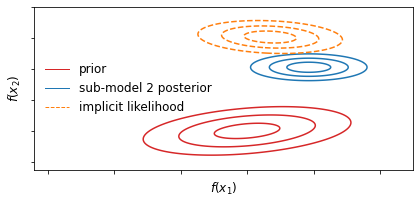

In [7]:
def plt_mvn(mu, Sigma, color='C0', linestyles='solid'):

    x, y = np.meshgrid(np.linspace(-3.2, 2.5, 300),np.linspace(-2.5 ,8,300))
    xy = np.column_stack([x.flat, y.flat])

    # density values at the grid points
    Z = mvn.pdf(xy, mu.flatten(), Sigma).reshape(x.shape)

    # arbitrary contour levels
    fig = plt.contour(x, y, Z, colors=color, levels=3, linestyles=linestyles, label='label')
    mup, Sp = np.zeros((2, 1)), kernel.K(Xt).numpy()


fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt_mvn(mup, Sp, 'C3')
plt_mvn(me1, Se1, 'C0')
plt_mvn(mpl1, Spl1, 'C1', linestyles='dashed')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='C3', lw=1),
                Line2D([0], [0], color='C0', lw=1),
                Line2D([0], [0], color='C1', linestyle="dashed", lw=1)]

ax.legend(custom_lines, ['prior', 'sub-model 2 posterior', 'implicit likelihood'], loc="center left", frameon=False)
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_xlabel("$f(x_1)$")
ax.set_ylabel("$f(x_2)$")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.tight_layout()

plt.savefig("toy_implicit_lik.pdf")

/var/folders/hf/nx4hh6mj3bsfyxc4p3splhxr0000gn/T/ipykernel_33571/52776853.py:61: UserWarning: The following kwargs were not used by contour: 'label'
  fig = plt.contour(x, y, Z, colors=color, levels=3, linestyles=linestyles, label='label')


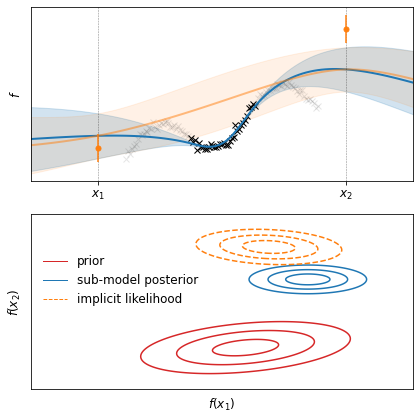

In [20]:
Xt = np.array([[-0.15, 1.15]]).T 
mup, Sp = np.zeros((2, 1)), kernel.K(Xt).numpy()

jitter = 1e-8 * np.eye(2)

me0, Se0 = M[0].predict_f(Xt, full_cov=True)
me0, Se0 = me0.numpy(), Se0.numpy()[0]
Spl0 = Sp @ np.linalg.inv(Sp - Se0 + jitter) @ Sp - Sp
Spl0 = np.linalg.inv(-np.linalg.inv(Sp) + np.linalg.inv(Se0) + jitter)
mpl0 = mup + Sp @ np.linalg.inv(Sp - Se0 + jitter) @ (me0 - mup)

me1, Se1 = M[1].predict_f(Xt, full_cov=True)
me1, Se1 = me1.numpy(), Se1.numpy()[0]
Spl1 = Sp @ np.linalg.inv(Sp - Se1 + jitter) @ Sp - Sp
Spl1 = np.linalg.inv(-np.linalg.inv(Sp) + np.linalg.inv(Se1) + jitter)
mpl1 = mup + Sp @ np.linalg.inv(Sp - Se1 + jitter) @ (me1 - mup)

me2, Se2 = M[2].predict_f(Xt, full_cov=True)
me2, Se2 = me2.numpy(), Se2.numpy()[0]
Spl2 = Sp @ np.linalg.inv(Sp - Se2 + jitter) @ Sp - Sp
Spl2 = np.linalg.inv(-np.linalg.inv(Sp) + np.linalg.inv(Se2) + jitter)
mpl2 = mup + Sp @ np.linalg.inv(Sp - Se2 + jitter) @ (me2 - mup)

# handmade predictions for full implicit posterior
x = np.linspace(-.5, 1.5, 101)[:, None]
kx = kernel.K(x, Xt).numpy()
kxx = kernel.K(x).numpy()
mx = kx @ np.linalg.inv(Sp + Spl1) @ mpl1
vx = kxx - kx @ np.linalg.inv(Sp + Spl1) @ kx.T
vx = np.diag(vx)[:, None]

# plot predictions
fig, axes = plt.subplots(2, 1, figsize=(6, 6))

x = np.linspace(-.5, 1.5, 101)[:, None]
axes[0].plot(X, Y, 'kx', alpha=0.1)
#[plot_model(m, axes, x, alpha=.3, plot_data=False) for i, m in enumerate(M)];
plot_model(M[1], axes[0], x)
#[axes[i].plot(X, Y, 'kx', mew=1., alpha=.1) for i, _ in enumerate(M)];
plot_mean_conf(x, mx, vx, axes[0], 'C1', alpha=.5)

[axes[0].axvline(x, color='k', linestyle="dashed", linewidth=.5, alpha=.5) for x in Xt]
[axes[0].plot(x, y, "C1o", ms=5.) for x, y in zip(Xt, mpl1)]
[axes[0].vlines(x, y-np.sqrt(c), y+np.sqrt(c) , "C1") for x, y, c in zip(Xt, mpl1, np.diag(Spl1))]
axes[0].set_xticks(Xt.flatten().tolist())
axes[0].set_xticklabels(["$x_1$", "$x_2$"])
axes[0].set_xlim([-.5, 1.5])
axes[0].set_yticks([])
axes[0].set_ylabel("$f$")

ax = axes[1]
def plt_mvn(mu, Sigma, color='C0', linestyles='solid'):

    x, y = np.meshgrid(np.linspace(-3.2, 2.5, 300),np.linspace(-2.5 ,8,300))
    xy = np.column_stack([x.flat, y.flat])

    # density values at the grid points
    Z = mvn.pdf(xy, mu.flatten(), Sigma).reshape(x.shape)

    # arbitrary contour levels
    fig = plt.contour(x, y, Z, colors=color, levels=3, linestyles=linestyles, label='label')

plt_mvn(mup, Sp, 'C3')
plt_mvn(me1, Se1, 'C0')
plt_mvn(mpl1, Spl1, 'C1', linestyles='dashed')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='C3', lw=1),
                Line2D([0], [0], color='C0', lw=1),
                Line2D([0], [0], color='C1', linestyle="dashed", lw=1)]

ax.legend(custom_lines, ['prior', 'sub-model posterior', 'implicit likelihood'], loc=(0.02, 0.45), frameon=False)
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_xlabel("$f(x_1)$")
ax.set_ylabel("$f(x_2)$")
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
plt.tight_layout()

plt.savefig("toy_implicit.pdf")

(2, 1) (2, 2)


/var/folders/hf/nx4hh6mj3bsfyxc4p3splhxr0000gn/T/ipykernel_33571/406059359.py:61: UserWarning: The following kwargs were not used by contour: 'label'
  fig = plt.contour(x, y, Z, colors=color, levels=3, linestyles=linestyles, label='label')


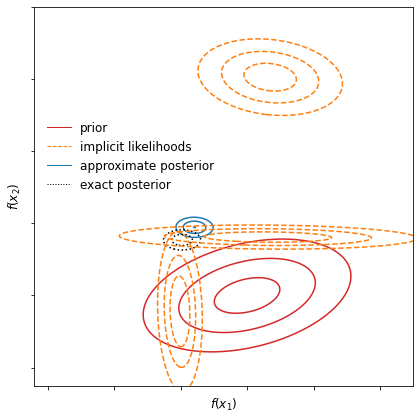

In [18]:
m_gpr = gpflow.models.GPR((X, Y), kernel, noise_variance=noise_var)
m_agg = guepard.PAPL(M)

mean_papl, var_papl = m_agg.predict_f(Xt, full_cov=True)
mean_papl, var_papl = mean_papl.numpy(), var_papl.numpy()[0]
mean_gpr, var_gpr = m_gpr.predict_f(Xt, full_cov=True)
mean_gpr, var_gpr = mean_gpr.numpy(), var_gpr.numpy()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
print(mean_gpr.shape, var_gpr.shape)
plt_mvn(mup, Sp, 'C3')
plt_mvn(mean_papl, var_papl, 'C0')
plt_mvn(mean_gpr, var_gpr, 'k', linestyles='dotted')
plt_mvn(mpl0, Spl0, 'C1', linestyles='dashed')
plt_mvn(mpl1, Spl1, 'C1', linestyles='dashed')
plt_mvn(mpl2, Spl2, 'C1', linestyles='dashed')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='C3', lw=1),
                Line2D([0], [0], color='C1', linestyle="dashed", lw=1),
                Line2D([0], [0], color='C0', lw=1),
                Line2D([0], [0], color='k', linestyle="dotted", lw=1)]

ax.legend(custom_lines, ['prior', 'implicit likelihoods', 'approximate posterior', 'exact posterior'], loc=(0.02, .5), frameon=False)

ax.set_xlabel("$f(x_1)$")
ax.set_ylabel("$f(x_2)$")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.tight_layout()
plt.savefig("toy_approx_posterior.pdf")
